# Preliminary procedures

First, we import the Transformer and Ethos libraries.

In [1]:
# First we are going to install the transformers library by hugging face!
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
! pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 37.3 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 22.0 MB/s 
     |████████████████████████████████| 6.8 MB 22.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#Then, we will clone the Ethos repo to extract the preprocessing pipeline and data
!git clone https://github.com/intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset/
!mv '/content/Ethos-Hate-Speech-Dataset/ethos/experiments' '/content/experiments'
!mv '/content/Ethos-Hate-Speech-Dataset/ethos/ethos_data' '/ethos_data'

Cloning into 'Ethos-Hate-Speech-Dataset'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 281 (delta 163), reused 115 (delta 50), pack-reused 0
Receiving objects: 100% (281/281), 12.67 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (163/163), done.


# Prepare Ethos Dataset

We now load the Ethos dataset.

In [3]:
import json
import numpy as np
import pandas as pd
import re
import os
from scipy.special import softmax

#We now import our data, after preprocessing them
from experiments.utilities.preprocess import Preproccesor
X, y = Preproccesor.load_data(preprocessed=True, stemming_a=False)

class_names = ['normalSpeech', 'hateSpeech']

In [4]:
print("Total amount:",len(y))
print("Hate speech:",sum(y))
print("Non Hate speech:",len(y)-sum(y))
print()
print("Example sample")
print(X[3])
print(y[3])

Total amount: 998
Hate speech: 433
Non Hate speech: 565

Example sample
would beat the shit out of every russian
1


# Prepare (Distil)Bert

We create the test dataset using the (Distil)Bert tokenizer.

In [6]:
import torch

from transformers import DistilBertTokenizerFast 
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

#Set training arguments
training_args = TrainingArguments(
    evaluation_strategy='epoch',     # evaluation frequency
    save_strategy='epoch',           # model checkpoint frequency
    logging_strategy='epoch',        # logging frequency
    log_level='warning',             # logging level
    output_dir='./results',          # output directory
    num_train_epochs=6,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation, change according to GPU memory capabilities
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,              # strength of weight decay
    logging_dir='./logs'             # directory for storing logs
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
#Create the test dataset
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

test_encodings = tokenizer(list(X), truncation=True, padding=True)              
test_dataset = HateSpeechDataset(test_encodings, y)

# Define performance metrics

We import accuracy, precision, recall and F1_score from sklearn, and define specificity and sensitivity.

In [8]:
#Define performance metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tn+fp) > 0:
        speci = tn/(tn+fp)
        return speci
    return 0

def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tp+fn) > 0:
        sensi = tp/(tp+fn)
        return sensi
    return 0

# Evaluate (Distil)BERT 

We now load the (Distil)Bert model, and then run the performance and metrics on the test dataset and output the results.

In [9]:
#Run a prediction on a dataset and return the probabilities
def model_predict(dataset):
    logits = trainer.predict(dataset).predictions
    probabilities = softmax(logits, axis = 1)
    return probabilities

#Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert_model/", output_attentions=False)

trainer = Trainer(
            model=model,                         
            args=training_args,                  
)
trainer.model = model.cuda()

In [10]:
probabilities = model_predict(test_dataset)

#Get predicted labels
y_preds = []
for i in probabilities:
    y_preds.append(np.argmax(i))

#Compute performance metrics
name = 'DistilBert'
performance_scores = {name:{}}
performance_scores[name]['F1'] = f1_score(y, y_preds, average='macro')
performance_scores[name]['Precision'] = precision_score(y, y_preds, average='macro')
performance_scores[name]['Recall'] = recall_score(y, y_preds, average='macro')
performance_scores[name]['Accuracy'] = accuracy_score(y, y_preds)
performance_scores[name]['Specificity'] = specificity(y, y_preds)
performance_scores[name]['Sensitivity'] = sensitivity(y, y_preds)

#Print metrics
pd.set_option('display.max_columns', None)
df = pd.DataFrame(performance_scores).T
df.to_csv('ethos_performance.csv')

# Create explanations

We will now run the LIME and IG techniques on 8 example samples and compare the explanations.

In [11]:
samples = [17, 4, 44, 3, 8, 27, 71, 74]
attributions = dict()
attributions['LIME'] = []
attributions['Integrated Gradients'] = []

In [12]:
#Import LIME
! pip install lime
import lime
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names, split_expression='\s+', bow=False)

#Predictor function for LIME
def predictor(texts):
    encodings = tokenizer(list(texts), truncation=True, padding=True)
    dataset = HateSpeechDataset(encodings, np.zeros(len(texts), dtype=int))
    probabilities = model_predict(dataset)
    return probabilities

for idx in samples:
    exp = explainer.explain_instance(X[idx], predictor, num_features=200, num_samples=2000)
    explanation_dict = dict(list(exp.as_map().values())[0])
    tokens = X[idx].split(' ')
    scores = []
    for i in range(len(tokens)):
        scores.append((tokens[i], explanation_dict[i]))
    attributions['LIME'].append(scores)

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=afe85e20649cbb567bb5decaadf22eddd69a1ca7280a4ef5619733792ab31b40
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [13]:
#Import Integrated Gradients
! pip install transformers-interpret
from transformers_interpret import SequenceClassificationExplainer

explainer = SequenceClassificationExplainer(model, tokenizer, custom_labels = class_names)
for idx in samples:
    test_phrase = X[idx]
    scores = explainer(test_phrase, class_name='hateSpeech')
    #Delete CLS and SEP tokens
    scores.pop(0)
    scores.pop(-1)
    attributions['Integrated Gradients'].append(scores)

     |████████████████████████████████| 1.4 MB 7.3 MB/s 
  Created wheel for transformers-interpret: filename=transformers_interpret-0.5.2-py3-none-any.whl size=23518 sha256=1a68c0503768dbb06ad1daa13a30b26998f110a2aafca149db5353aaf0bf11d6
  Stored in directory: /root/.cache/pip/wheels/18/8a/5f/db643e1cd44e7bb22c21b52b8fcaebadafaf0b361c33f05869
Successfully built transformers-interpret


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

# Plotting Code from innvestigate library: https://github.com/albermax/innvestigate
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

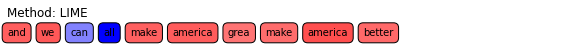

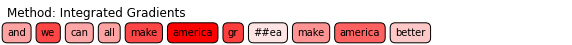

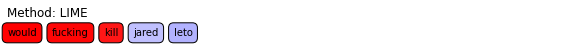

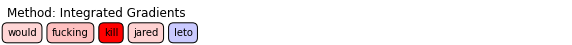

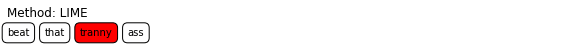

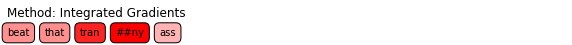

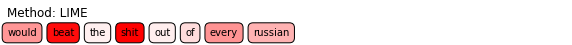

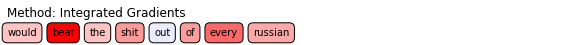

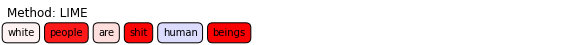

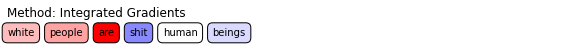

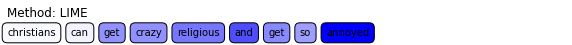

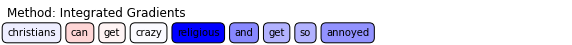

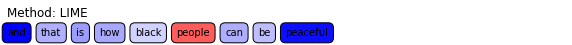

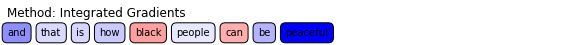

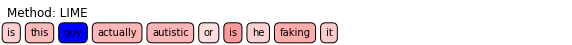

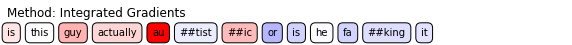

In [15]:
# Plotting
methods = ['LIME', 'Integrated Gradients']

for sample_id in range(len(samples)):
    for method in methods:
        analysis = attributions[method][sample_id]
        words = [t[0] for t in analysis]
        scores = np.array([t[1] for t in analysis])
        plot_text_heatmap(words, scores, title='Method: %s' % method, verbose=0)
    plt.show()